In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.ticker import NullLocator, LinearLocator, MultipleLocator, IndexLocator, FixedLocator, LogLocator, MaxNLocator
from matplotlib.ticker import NullFormatter, FormatStrFormatter, FuncFormatter, ScalarFormatter, FixedFormatter

# 1997 - 2006, 2009 - 2023 погода Рязань

# все годы
      t  - температура
      p  - давление
      ws - скорость ветра
    wdir - направление ветра

In [2]:
weather = pd.read_csv('weather.csv', index_col = ['year','month','day'])
weather.shape

(8759, 6)

# Давление

##### среднее и медианное давление

In [32]:
pmean = weather[['p(day)', 'p(night)']].mean().round(2)
pmed = weather[['p(day)', 'p(night)']].median()
print('среднее давление днем составляет:', pmean.loc['p(day)'], 'мм.рт.ст.,', 
      'медианное дневное давление:', pmed.loc['p(day)'],
     '\nсреднее давление ночью составляет:', pmean.loc['p(night)'], 'мм.рт.ст.,',
     'медианное ночное давление:', pmed.loc['p(night)'],)

среднее давление днем составляет: 747.38 мм.рт.ст., медианное дневное давление: 747.0 
среднее давление ночью составляет: 747.39 мм.рт.ст., медианное ночное давление: 747.0


###### минимальное и максимальное давление

In [33]:
pmin = weather[['p(day)', 'p(night)']].min()
pmax = weather[['p(day)', 'p(night)']].max()
print('показатель минимального дневного давления:', pmin['p(day)'], 'мм.рт.ст., ночного:', pmin['p(night)'],
     '\nмаксимальное зарегистрированное давление днем:', pmax['p(day)'], 'мм.рт.ст., ночное:', pmax['p(night)'])

показатель минимального дневного давления: 717 мм.рт.ст., ночного: 716 
максимальное зарегистрированное давление днем: 776 мм.рт.ст., ночное: 776


##### разница между дневным и вечерним давлением

In [4]:
#добавляем столбец с разницей дневного и вечернего давления по модулю
weather.insert(loc=6, 
               column='pdiff', 
               value=weather[['p(day)', 'p(night)']].apply(lambda row: abs(row['p(day)'] - row['p(night)']), axis=1))

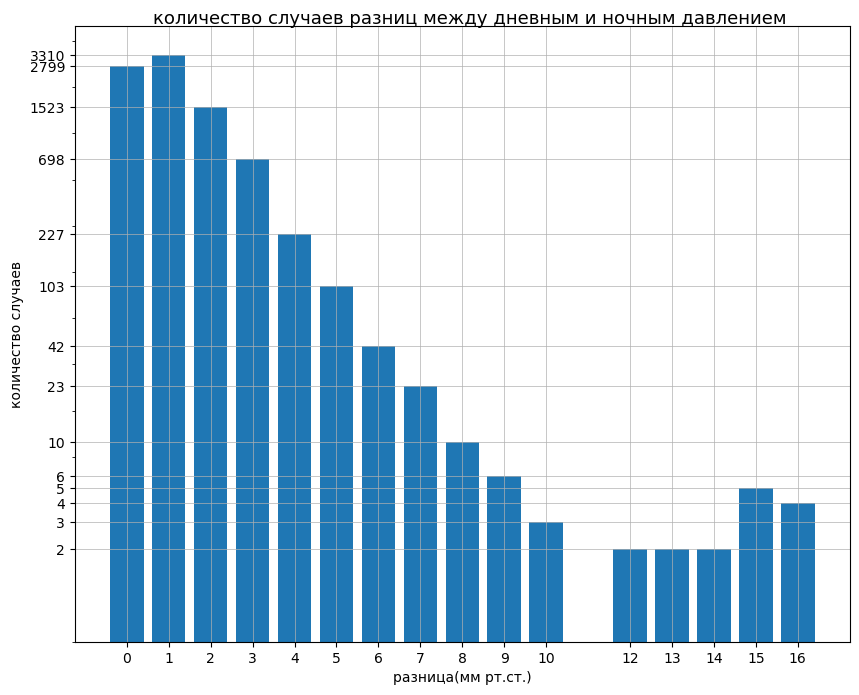

In [5]:
countpdiff = weather.groupby('pdiff')['pdiff'].count()
fig13 = plt.figure(figsize=(10, 8))
fig13.suptitle('количество случаев разниц между дневным и ночным давлением',x=0.52,y=0.90, fontsize=13)
ax_cpd = fig13.add_subplot()
ax_cpd.set_yscale('symlog', base=2)
ax_cpd.bar(x=countpdiff.index.values, height=countpdiff)
ax_cpd.set_xlabel('разница(мм рт.ст.)')
ax_cpd.set_ylabel('количество случаев')
ax_cpd.grid(which='major', lw=0.5)
ax_cpd.xaxis.set_major_locator(FixedLocator(countpdiff.index))
ax_cpd.yaxis.set_major_locator(FixedLocator(np.unique(countpdiff.sort_values().values)))
ax_cpd.yaxis.set_major_formatter(FixedFormatter(np.unique(countpdiff.sort_values().values)))
ax_cpd.tick_params(axis='y', which='major', labelsize=10);

##### межгодовая разница среднего давления

In [6]:
#группируем данные
ygp = weather.groupby('year').agg({'p(day)':'mean', 'p(night)':'mean'}).round(2)
#новый фрейм с годами в index и columns
yearspdiff = pd.DataFrame(columns=weather.index.levels[0], index=weather.index.levels[0][::-1])
#заполняем данными
for i in weather.index.levels[0]:
    for j in weather.index.levels[0]:
        yearspdiff[i].loc[j] = ygp['p(day)'].loc[i] - ygp['p(night)'].loc[j]
yearspdiff = yearspdiff.astype('float64')

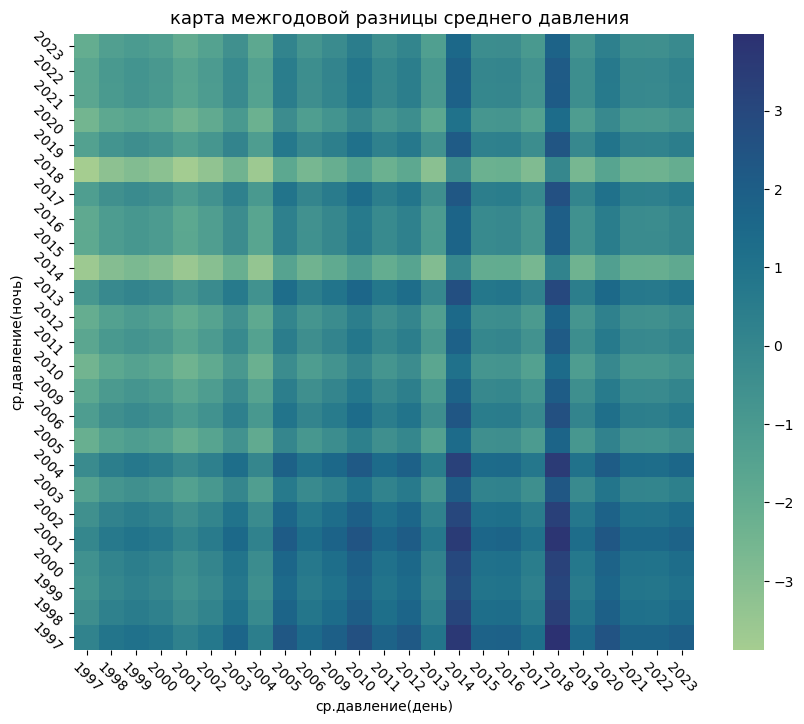

In [7]:
fig14 = plt.figure(figsize=(10, 8))
fig14.suptitle('карта межгодовой разницы среднего давления',x=0.45,y=0.91, fontsize=13)
ax_ypd = fig13.add_subplot()
ax_ypd = sns.heatmap(yearspdiff, cmap='crest')
ax_ypd.tick_params(axis ='x', rotation = -45)
ax_ypd.tick_params(axis ='y', rotation = -45)
ax_ypd.set(xlabel="ср.давление(день)", ylabel="ср.давление(ночь)");

### годовое среднее давление

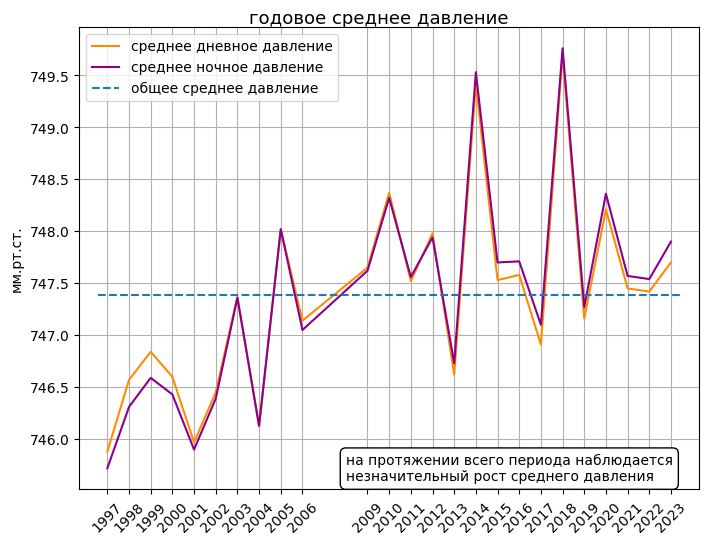

In [8]:
fig15 = plt.figure(figsize=(8, 6))
fig15.suptitle('годовое среднее давление',x=0.5,y=0.91, fontsize=13)
ax_ygp = fig15.add_subplot()
ax_ygp.plot(ygp['p(day)'], label='среднее дневное давление', c='DarkOrange')
ax_ygp.plot(ygp['p(night)'], label='среднее ночное давление', c='DarkMagenta')
ax_ygp.axhline(y=pmean.mean(), xmin=0.03, xmax=0.97, label='общее среднее давление', linestyle='--')
ax_ygp.xaxis.set_major_locator(FixedLocator(ygp.index))
ax_ygp.tick_params(axis ='x', rotation = 45)
ax_ygp.legend(loc=2)
ax_ygp.set_ylabel('мм.рт.ст.')
ax_ygp.text(x=2008, y=745.6, s='на протяжении всего периода наблюдается\nнезначительный рост среднего давления', 
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.4'))
ax_ygp.grid();

### среднее давление по месяцам

In [9]:
dictmonth = {1: {'a': 'Ян', 'f': 'Январь'}, 2: {'a': 'Фе', 'f': 'Февраль'}, 
             3: {'a': 'Март', 'f': 'Март'}, 4: {'a': 'Ап', 'f': 'Апрель'},
             5: {'a': 'Май', 'f': 'Май'},   6: {'a': 'Июнь', 'f': 'Июнь'},
             7: {'a': 'Июль', 'f': 'Июль'}, 8: {'a': 'Ав', 'f': 'Август'},
             9: {'a': 'Се', 'f': 'Сентябрь'}, 10: {'a': 'Ок', 'f': 'Октябрь'},
            11: {'a': 'Но', 'f': 'Ноябрь'},   12: {'a': 'Де', 'f': 'Декабрь'}}

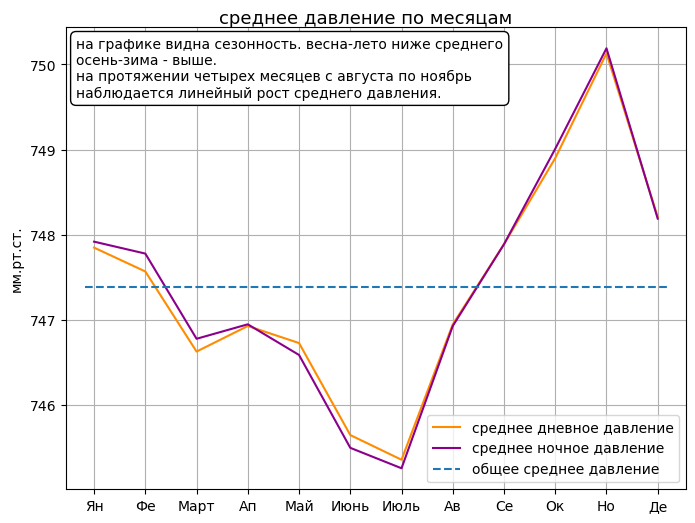

In [173]:
mgp = weather.groupby('month').agg({'p(day)':'mean', 'p(night)':'mean'}).round(2)
fig16 = plt.figure(figsize=(8, 6))
fig16.suptitle('среднее давление по месяцам',x=0.5,y=0.91, fontsize=13)
ax_mgp = fig16.add_subplot()
ax_mgp.plot(mgp['p(day)'], label='среднее дневное давление', c='DarkOrange')
ax_mgp.plot(mgp['p(night)'], label='среднее ночное давление', c='DarkMagenta')
ax_mgp.axhline(y=pmean.mean(), xmin=0.03, xmax=0.97, label='общее среднее давление', linestyle='--')
ax_mgp.xaxis.set_major_locator(FixedLocator(mgp.index))
ax_mgp.xaxis.set_major_formatter(FixedFormatter([dictmonth[i]['a'] for i in range(1, 13)]))
ax_mgp.legend(loc=4)
ax_mgp.set_ylabel('мм.рт.ст.')
ax_mgp.text(x=0.65, y=749.62, s='на графике видна сезонность. весна-лето ниже среднего\
\nосень-зима - выше. \
\nна протяжении четырех месяцев с августа по ноябрь\
\nнаблюдается линейный рост среднего давления.', 
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.4'))
ax_mgp.grid();

### количество случаев каждой зарегистрированной величины давления

In [121]:
#фрейм со всеми величинами давления и количество случаев величины для каждого времени суток 
countp = pd.DataFrame([[i, 
                      [vcpd[i] if i in vcpd.index else 0, 
                       vcpn[i] if i in vcpn.index else 0]] 
                      for i in np.arange(pmin.min(), pmax.max()+1)], columns=['p', 'day'])
countp['night'], countp['day'] = countp.apply(lambda row:row[1][1], axis=1), countp.apply(lambda row:row[1][0], axis=1)

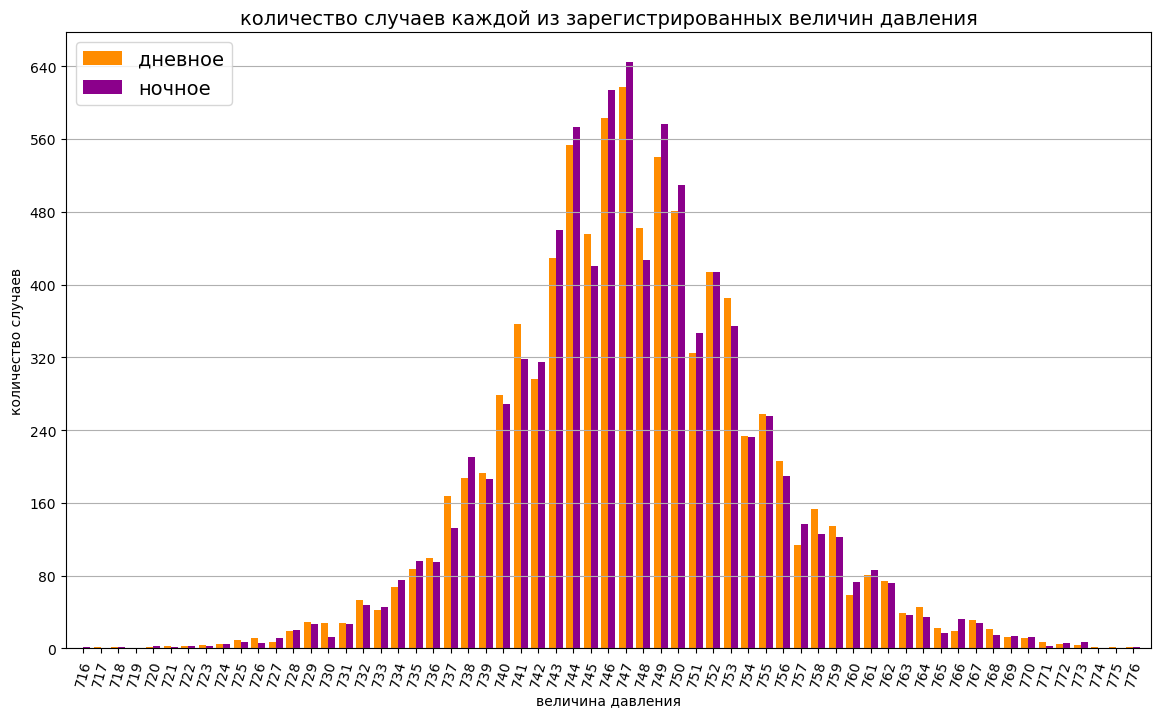

In [180]:
width = 0.4
fig17 = plt.figure(figsize=(14, 8))
ax_cp = fig17.add_subplot()
ax_cp.bar(countp['p'] - width/2, countp['day'], width, label='дневное', color='DarkOrange')
ax_cp.bar(countp['p'] + width/2, countp['night'], width, label='ночное', color='DarkMagenta')
ax_cp.set_title('количество случаев каждой из зарегистрированных величин давления', fontsize=14)
ax_cp.set_xticks(countp['p'])
ax_cp.yaxis.set_major_locator(MaxNLocator(10))
ax_cp.tick_params(axis ='x', rotation = 75)
ax_cp.set_ylabel('количество случаев')
ax_cp.set_xlabel('величина давления')
ax_cp.legend(loc=2, fontsize=14)
ax_cp.grid(axis='y')
plt.xlim(pmin.min()-1, pmax.max()+1);

### рассеивание суточных показателей

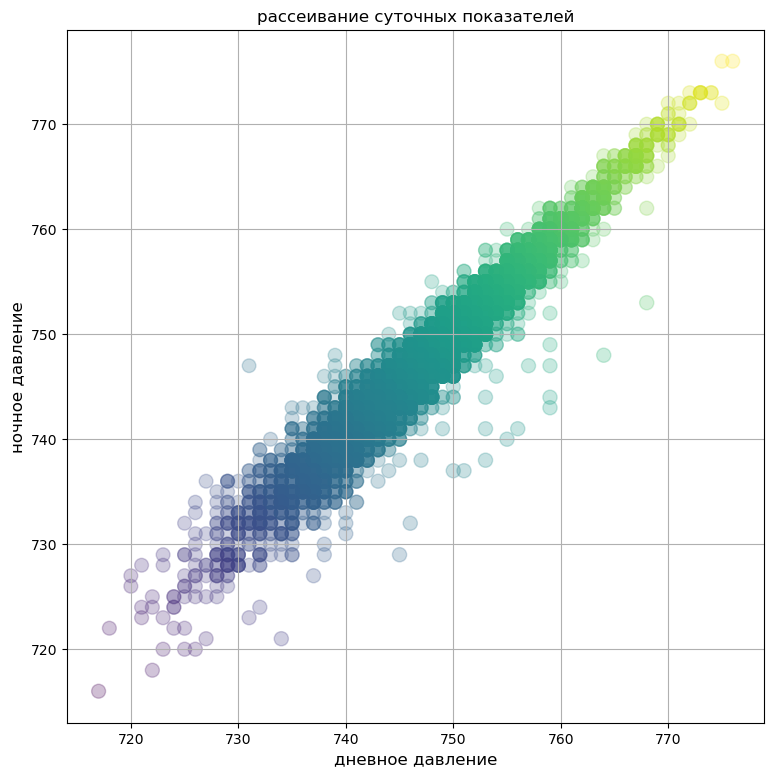

In [195]:
fig18 = plt.figure(figsize=(9, 9))
ax_ = fig18.add_subplot()
s = (10 * weather['p(day)'] / weather['p(night)'])**2
c = 0.001 * weather['p(day)'] / 0.001 * weather['p(night)']
ax_.scatter(weather['p(day)'], weather['p(night)'], c=c, s=s, alpha=0.25)
ax_.set_xlabel('дневное давление', fontsize=12)
ax_.set_ylabel('ночное давление', fontsize=12)
ax_.set_title('рассеивание суточных показателей')
ax_.grid();